In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.special as special

### 输入数据

In [19]:
n_data = [582594, 169628, 159516, 137877, 130072, 89569,
          73303, 61049, 30589, 26712, 25688, 25680]   # 确诊数
y_data = [23649, 17628, 20465, 14986, 3194, 11346,
          4585, 1296, 3903, 2833, 1138, 780]   # 死亡数

n = [i/10000 for i in n_data]
y = [i/10000 for i in y_data]

### 首先用点估计方法看一下 $\alpha,\beta$ 的大概值

In [20]:
# 点估计方法
theta = []
for i in range(len(n_data)-1):
    theta.append(y_data[i]/n_data[i])
E_theta = np.mean(theta)
D_theta = np.var(theta)
print('point estimates')
print('E(theta)=%(e).5f,\tD(theta)=%(v).5f' %\
    {'e':E_theta, 'v':D_theta})
# solution of the point estimate
beta = (E_theta*(1-E_theta)/D_theta-1)*(1-E_theta)
alpha = E_theta*beta/(1-E_theta)
print('\nEstimates for the parameters of the prior density')
print('alpha=%(a).5f,\tbeta=%(b).5f' % {'a':alpha, 'b':beta})

point estimates
E(theta)=0.08131,	D(theta)=0.00168

Estimates for the parameters of the prior density
alpha=3.53215,	beta=39.90602


### 使用 $p(\alpha,\beta)\propto (\alpha+\beta)^{-5/2}$ 的均匀分布 计算边缘后验分布（对数形式）

max-p: -46.905336036739286 min-p: -147.41100301321435
max likeli alpha=0.850, beta=6.500


F:\Anaconda\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


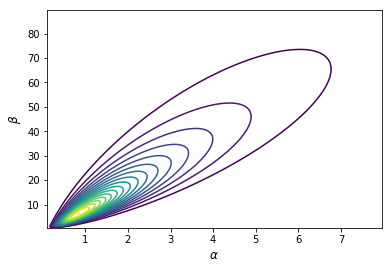

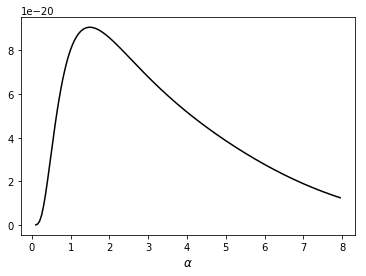

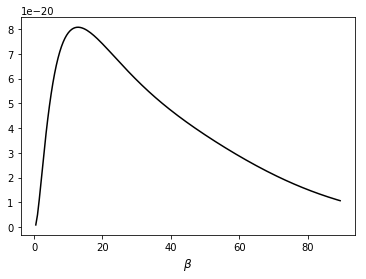

In [24]:
def posteriorln(x,y,n):
    '''
    posterior density in log scale
    '''
    alpha = x[0]
    beta = x[1]
    lnlikeli = 0.
    for j in range(len(y)):
        lnlikeli += special.gammaln(alpha+beta)+\
            special.gammaln(alpha+y[j])+\
            special.gammaln(beta+n[j]-y[j])-\
            special.gammaln(alpha)-special.gammaln(beta)-\
            special.gammaln(alpha+beta+n[j])   
    priorln = -5./2.*np.log(alpha+beta) # non-information prior（alpha beta 的先验分布）
    return lnlikeli+priorln  #+365400. 如果使用原始数据需要加上
                             # 返回 alpha beta 的边缘后验分布

        
def draw_posterior(y,n,alphagrid,betagrid):
    '''
    Calculate posterior density at a fixed 2D grid of parameters
    '''
    p = np.zeros((len(alphagrid),len(betagrid)))
    for i in range(len(alphagrid)):
        for j in range(len(betagrid)):
            p[i,j] = posteriorln([alphagrid[i],betagrid[j]],y,n)
            #print(p[i,j])
    print('max-p:', np.max(p), 'min-p:', np.min(p))
    return p


alphagrid = np.arange(0.1,8,0.05)
betagrid = np.arange(0.5,90,0.5)
p = draw_posterior(y, n, alphagrid, betagrid)

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ii = np.argmax(p.T)
amesh_f = amesh.flatten()
bmesh_f = bmesh.flatten()
print('max likeli alpha=%(a).3f, beta=%(b).3f' % {'a':amesh_f[ii],'b':bmesh_f[ii]})
ax.contour(amesh, bmesh, np.exp(p.T),20,\
            extent=[alphagrid[0],\
            alphagrid[-1],betagrid[0],betagrid[-1]])
ax.set_xlabel(r'$\alpha$',fontsize=12)
ax.set_ylabel(r'$\beta$',fontsize=12)
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.plot(alphagrid, np.sum(np.exp(p), axis=1),'k-')
ax.set_xlabel(r'$\alpha$',fontsize=12)
fig.show()
        
fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.plot(betagrid, np.sum(np.exp(p), axis=0),'k-')
ax.set_xlabel(r'$\beta$',fontsize=12)
fig.show()

### 使用 $p(ln(\alpha / \beta),ln(\alpha+\beta))\propto \alpha \beta(\alpha+\beta)^{-5/2}$ 超先验计算边缘后验分布

max-p: -43.57199382706769 min-p: -67.04641030412344
max likeli a=-2.360, b=4.070
max likeli alpha=5.052, beta=53.505
-43.57199382706769


F:\Anaconda\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


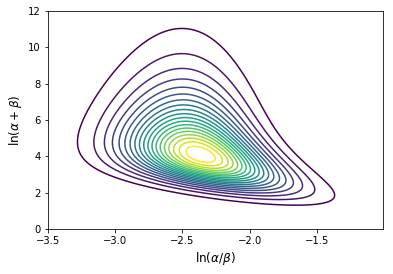

In [29]:
def draw_posteriorln(y,n,agrid,bgrid):
    '''
    Draw posterior density at 2D grid of parameters in log scales
    prior is non-informative
    agrid and bgrid are in log scales
    '''
    p = np.zeros((len(agrid),len(bgrid)))
    for i in range(len(agrid)):
        for j in range(len(bgrid)):
            #convert it back to linear scale and obtain alpha and beta
            alpha = np.exp(agrid[i]+bgrid[j])/(1+np.exp(agrid[i]))
            beta = np.exp(bgrid[j])/(1+np.exp(agrid[i]))
            #print alpha,beta
            Jacob_detln = -np.log(alpha)-np.log(beta)
            #calculate posterior density in log scale
            p[i,j] = posteriorln([alpha,beta],y,n)-Jacob_detln
    print('max-p:', np.max(p), 'min-p:', np.min(p))
    return p

agrid = np.arange(-3.5,-1,0.01)
bgrid = np.arange(0,12,0.01)
p2 = draw_posteriorln(y,n,agrid,bgrid)
#print(p2.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(agrid,bgrid)
ii = np.argmax(p2.T)
amesh_f = amesh.flatten()
bmesh_f = bmesh.flatten()
print('max likeli a=%(a).3f, b=%(b).3f' % {'a':amesh_f[ii],'b':bmesh_f[ii]})
alpha = np.exp(amesh_f[ii]+bmesh_f[ii])/(1+np.exp(amesh_f[ii]))
beta = np.exp(bmesh_f[ii])/(1+np.exp(amesh_f[ii]))
print('max likeli alpha=%(a).3f, beta=%(b).3f' % {'a':alpha,'b':beta})
ax.contour(amesh, bmesh, np.exp(p2.T),20,\
            extent=[alphagrid[0],\
            alphagrid[-1],betagrid[0],betagrid[-1]])
ax.set_xlabel(r'$\ln(\alpha/\beta)$',fontsize=12)
ax.set_ylabel(r'$\ln(\alpha+\beta)$',fontsize=12)
fig.show()

print(np.max((p2.T)))

### $\theta$ 的后验分布

mean(theta|alpha,beta,y)=0.07237
std(theta|alpha,beta,y)=0.00898


F:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
F:\Anaconda\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


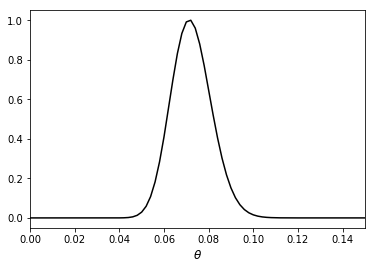

In [33]:
theta = np.arange(0,1,0.002)
pln = np.zeros(np.shape(theta))
for j in range(len(y_data)):
    # Conjugate posterior
    a = alpha+y[j]#a+y
    b = beta+n[j]-y[j]#b+n-y
    pln = pln+np.log(stats.beta.pdf(theta,a,b))
    
p = np.exp(pln-np.max(pln))

mean_theta_post = np.sum(p*theta)/np.sum(p)
std_theta_post = np.sqrt(np.sum(p*(theta-mean_theta_post)**2)/np.sum(p))
print('mean(theta|alpha,beta,y)=%(p).5f' %{'p':mean_theta_post})
print('std(theta|alpha,beta,y)=%(p).5f' %{'p':std_theta_post})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta,p,'k-')
ax.set_xlabel(r'$\theta$',fontsize=12)
ax.set_xlim(0,0.15)
fig.show()